In [17]:
import tensorflow as tf
print(tf.__version__)
tf.config.list_physical_devices('GPU')
from tensorflow.python.client import device_lib
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

# !pip install git+https://github.com/karolzak/keras-unet
!git clone https://github.com/karolzak/keras-unet
import keras
print(keras.__version__)

import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))

import sys

from sklearn import datasets
from sklearn.model_selection import train_test_split

# import tensorflow.keras as keras 
import numpy as np
import matplotlib.pyplot as plt
import os
import SimpleITK as sitk
import math
import keras 

from keras.utils.np_utils import to_categorical
from tensorflow.keras import optimizers 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Dropout, Input, Lambda, Reshape, AveragePooling2D, BatchNormalization
from keras.layers.merge import add, concatenate
from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions

from keras.models import Model
from keras.layers.merge import concatenate
from keras.layers import Input, Convolution3D, MaxPooling3D, UpSampling3D
from keras.layers import Reshape, Activation
from keras.layers.normalization import BatchNormalization

from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization

from keras_unet.utils import plot_imgs, get_augmented, plot_segm_history
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance 
from keras_unet.models import custom_unet

from tensorflow.keras.optimizers import Adam, SGD

print(keras.__version__)

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

from volumentations import *

!git clone https://github.com/dhuy228/augmented-volumetric-image-generator
!git clone https://github.com/imlab-uiip/lung-segmentation-3d.git
!mv augmented-volumetric-image-generator augmented # rename directory to augmented
!mv lung-segmentation-3d unet # rename directory to unet
from augmented import generator
from unet.build_model import build_model   

import numpy as np
import tensorflow as tf
import nibabel as nib
import glob
import time
from tensorflow.keras.utils import to_categorical
from sys import stdout
import matplotlib.pyplot as plt
import matplotlib.image as mpim
from scipy.ndimage.interpolation import affine_transform
from augmentation import *
from sklearn.model_selection import train_test_split

2.4.1
fatal: destination path 'keras-unet' already exists and is not an empty directory.
2.4.3
matplotlib: 3.3.4
2.4.3
fatal: destination path 'augmented-volumetric-image-generator' already exists and is not an empty directory.
fatal: destination path 'lung-segmentation-3d' already exists and is not an empty directory.
mv: cannot move 'augmented-volumetric-image-generator' to 'augmented/augmented-volumetric-image-generator': Directory not empty
mv: cannot move 'lung-segmentation-3d' to 'unet/lung-segmentation-3d': Directory not empty


In [18]:
# delete .DS_Store file in each folder 

# resample
            
resampath =  '/home/gpuadmin/anaconda3/envs/py380/Work/Segmentation_UNet/T1NORM_RESAMPLE2/train/'
resampfile = os.listdir(resampath)
resampfile.sort()
num_seg = len(resampfile)
count_seg = 0
for item_resamp in os.listdir(resampath):
    current_resamp = os.path.basename(item_resamp)
    if current_resamp == '.DS_Store':
        fullpath = os.path.join(resampath,current_resamp)
        os.remove(fullpath)

In [19]:
# feature for deep learning (3D): img

resampath = '/home/gpuadmin/anaconda3/envs/py380/Work/Segmentation_UNet/T1NORM_RESAMPLE2/train/'
resampfile = os.listdir(resampath)
resampfile.sort()
num_img = len(resampfile)

first = sitk.ReadImage(os.path.join(resampath,resampfile[0]))
feature = sitk.GetArrayFromImage(first)
feature_temp = feature.transpose(1,2,0)
feature_reshape = feature_temp.reshape(1, feature_temp.shape[0], feature_temp.shape[1], feature_temp.shape[2], 1)

num = 1

for n in os.listdir(resampath):

    i = sitk.ReadImage(os.path.join(resampath,resampfile[num]))
    j = sitk.GetArrayFromImage(i)
    j_temp = j.transpose(1,2,0)
    j_reshape = j_temp.reshape(1, j_temp.shape[0], j_temp.shape[1], j_temp.shape[2], 1)
    
    feature_reshape = np.concatenate([feature_reshape,j_reshape], axis = 0)
    
feature_reshape = feature_reshape[0:50,:,:,:,:]

In [20]:
# feature for deep learning (3D): mask

resampath = '/home/gpuadmin/anaconda3/envs/py380/Work/Segmentation_UNet/ROI_RAD_RESAMPLE2/train/'
resampfile = os.listdir(resampath)
resampfile.sort()
num_img = len(resampfile)

first = sitk.ReadImage(os.path.join(resampath,resampfile[0]))
mask = sitk.GetArrayFromImage(first)
mask_temp = mask.transpose(1,2,0)
mask_reshape = mask_temp.reshape(1, mask_temp.shape[0], mask_temp.shape[1], mask_temp.shape[2], 1)

num = 1

for n in os.listdir(resampath):

    i = sitk.ReadImage(os.path.join(resampath,resampfile[num]))
    j = sitk.GetArrayFromImage(i)
    j_temp = j.transpose(1,2,0)
    j_reshape = j_temp.reshape(1, j_temp.shape[0], j_temp.shape[1], j_temp.shape[2], 1)
    
    mask_reshape = np.concatenate([mask_reshape,j_reshape], axis = 0)
    
mask_reshape = mask_reshape[0:50,:,:,:]

In [21]:
# feature normalization: 0-1

maxval = np.amax(feature)
feature_norm = feature_reshape/maxval

In [22]:
x_train = feature_reshape
y_train = mask_reshape 

print(x_train.shape)
print(y_train.shape)

(50, 128, 128, 32, 1)
(50, 128, 128, 32, 1)


In [23]:
# delete .DS_Store file in each folder 

# resample
            
resampath =  '/home/gpuadmin/anaconda3/envs/py380/Work/Segmentation_UNet/ROI_RAD_RESAMPLE2/test/'
resampfile = os.listdir(resampath)
resampfile.sort()
num_seg = len(resampfile)
count_seg = 0
for item_resamp in os.listdir(resampath):
    current_resamp = os.path.basename(item_resamp)
    if current_resamp == '.DS_Store':
        fullpath = os.path.join(resampath,current_resamp)
        os.remove(fullpath)

In [24]:
# feature for deep learning (3D): img

resampath = '/home/gpuadmin/anaconda3/envs/py380/Work/Segmentation_UNet/T1NORM_RESAMPLE2/test/'
resampfile = os.listdir(resampath)
resampfile.sort()
num_img = len(resampfile)

first = sitk.ReadImage(os.path.join(resampath,resampfile[0]))
feature = sitk.GetArrayFromImage(first)
feature_temp = feature.transpose(1,2,0)
feature_reshape = feature_temp.reshape(1, feature_temp.shape[0], feature_temp.shape[1], feature_temp.shape[2], 1)

num = 1

for n in os.listdir(resampath):

    i = sitk.ReadImage(os.path.join(resampath,resampfile[num]))
    j = sitk.GetArrayFromImage(i)
    j_temp = j.transpose(1,2,0)
    j_reshape = j_temp.reshape(1, j_temp.shape[0], j_temp.shape[1], j_temp.shape[2], 1)
    
    feature_reshape = np.concatenate([feature_reshape,j_reshape], axis = 0)
    
feature_reshape = feature_reshape[0:50,:,:,:,:]

In [25]:
# feature for deep learning (3D): mask

resampath = '/home/gpuadmin/anaconda3/envs/py380/Work/Segmentation_UNet/ROI_RAD_RESAMPLE2/test/'
resampfile = os.listdir(resampath)
resampfile.sort()
num_img = len(resampfile)

first = sitk.ReadImage(os.path.join(resampath,resampfile[0]))
mask = sitk.GetArrayFromImage(first)
mask_temp = mask.transpose(1,2,0)
mask_reshape = mask_temp.reshape(1, mask_temp.shape[0], mask_temp.shape[1], mask_temp.shape[2], 1)

num = 1

for n in os.listdir(resampath):

    i = sitk.ReadImage(os.path.join(resampath,resampfile[num]))
    j = sitk.GetArrayFromImage(i)
    j_temp = j.transpose(1,2,0)
    j_reshape = j_temp.reshape(1, j_temp.shape[0], j_temp.shape[1], j_temp.shape[2], 1)
    
    mask_reshape = np.concatenate([mask_reshape,j_reshape], axis = 0)
    
mask_reshape = mask_reshape[0:50,:,:,:]

In [26]:
x_val = feature_reshape
y_val = mask_reshape 

print(x_val.shape)
print(y_val.shape)

(50, 128, 128, 32, 1)
(50, 128, 128, 32, 1)


In [27]:
inp_shape = x_train[0].shape
k_size = 4

merge_axis = -1 # Feature maps are concatenated along last axis (for tf backend)
data = Input(shape = inp_shape)

y_train = y_train.astype(np.uint8)
y_train_c = to_categorical(y_train, 2, dtype = 'uint8')

y_val = y_val.astype(np.uint8)
y_val_c = to_categorical(y_val, 2, dtype = 'uint8')

In [28]:
# Create image data generators for both train and validation sets

bs = 2
seed = 10
                         
image_aug = generator.customImageDataGenerator(rotation_range = 20)    
mask_aug = generator.customImageDataGenerator(rotation_range = 20)

X_train_datagen = image_aug.flow(x_train, batch_size = bs, seed = seed) # set equal seed number
Y_train_datagen = mask_aug.flow(y_train, batch_size = bs, seed = seed) # set equal seed number
train_generator = zip(X_train_datagen, Y_train_datagen)

X_validation_datagen = image_aug.flow(x_val, batch_size = bs, seed = seed) # set equal seed number
Y_validation_datagen = mask_aug.flow(y_val, batch_size = bs, seed = seed) # set equal seed number
validation_generator = zip(X_validation_datagen, Y_validation_datagen)

In [29]:
from keras.models import Model
from keras.layers.merge import concatenate
from keras.layers import Input, Convolution3D, MaxPooling3D, UpSampling3D
from keras.layers import Reshape, Activation
from keras.layers.normalization import BatchNormalization

def build_model(inp_shape, k_size = 4):
    
    merge_axis = -1 # Feature maps are concatenated along last axis (for tf backend)
    data = Input(shape=inp_shape)
    
    conv1 = Convolution3D(padding = 'same', filters = 32, kernel_size = k_size, kernel_initializer='he_normal')(data)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    
    conv2 = Convolution3D(padding = 'same', filters = 32, kernel_size = k_size, kernel_initializer='he_normal')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    
    pool1 = MaxPooling3D(pool_size = (2, 2, 2))(conv2)
    # pool1 = Dropout(0.3)(pool1)

    conv3 = Convolution3D(padding = 'same', filters = 64, kernel_size = k_size, kernel_initializer='he_normal')(pool1)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    
    conv4 = Convolution3D(padding = 'same', filters = 64, kernel_size = k_size, kernel_initializer='he_normal')(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    
    pool2 = MaxPooling3D(pool_size = (2, 2, 2))(conv4)
    # pool2 = Dropout(0.3)(pool2)

    conv5 = Convolution3D(padding = 'same', filters = 64, kernel_size = k_size, kernel_initializer='he_normal')(pool2)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    
    conv6 = Convolution3D(padding = 'same', filters = 64, kernel_size = k_size, kernel_initializer='he_normal')(conv5)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    
    pool3 = MaxPooling3D(pool_size = (2, 2, 2))(conv6)
    # pool3 = Dropout(0.3)(pool3)

    conv7 = Convolution3D(padding = 'same', filters = 128, kernel_size = k_size, kernel_initializer='he_normal')(pool3)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)
    
    conv8 = Convolution3D(padding = 'same', filters = 128, kernel_size = k_size, kernel_initializer='he_normal')(conv7)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)
    
    pool4 = MaxPooling3D(pool_size = (2, 2, 2))(conv8)
    # pool4 = Dropout(0.3)(pool4)
    
    conv9 = Convolution3D(padding = 'same', filters = 128, kernel_size = k_size, kernel_initializer='he_normal')(pool4)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)

    up1 = UpSampling3D(size = (2, 2, 2))(conv9)
    
    conv10 = Convolution3D(padding = 'same', filters = 128, kernel_size = k_size, kernel_initializer='he_normal')(up1)
    conv10 = BatchNormalization()(conv10)
    conv10 = Activation('relu')(conv10)
    
    conv11 = Convolution3D(padding = 'same', filters = 128, kernel_size = k_size, kernel_initializer='he_normal')(conv10)
    conv11 = BatchNormalization()(conv11)
    conv11 = Activation('relu')(conv11)
    
    merged1 = concatenate([conv11, conv8], axis = merge_axis)
    
    conv12 = Convolution3D(padding = 'same', filters = 128, kernel_size = k_size, kernel_initializer='he_normal')(merged1)
    conv12 = BatchNormalization()(conv12)
    conv12 = Activation('relu')(conv12)

    up2 = UpSampling3D(size=(2, 2, 2))(conv12)
    
    conv13 = Convolution3D(padding = 'same', filters = 64, kernel_size = k_size, kernel_initializer='he_normal')(up2)
    conv13 = BatchNormalization()(conv13)
    conv13 = Activation('relu')(conv13)
    
    conv14 = Convolution3D(padding = 'same', filters = 64, kernel_size = k_size, kernel_initializer='he_normal')(conv13)
    conv14 = BatchNormalization()(conv14)
    conv14 = Activation('relu')(conv14)
    
    merged2 = concatenate([conv14, conv6], axis = merge_axis)
    
    conv15 = Convolution3D(padding = 'same', filters = 64, kernel_size=k_size, kernel_initializer='he_normal')(merged2)
    conv15 = BatchNormalization()(conv15)
    conv15 = Activation('relu')(conv15)

    up3 = UpSampling3D(size=(2, 2, 2))(conv15)
    
    conv16 = Convolution3D(padding = 'same', filters = 64, kernel_size = k_size, kernel_initializer='he_normal')(up3)
    conv16 = BatchNormalization()(conv16)
    conv16 = Activation('relu')(conv16)
    
    conv17 = Convolution3D(padding = 'same', filters = 64, kernel_size = k_size, kernel_initializer='he_normal')(conv16)
    conv17 = BatchNormalization()(conv17)
    conv17 = Activation('relu')(conv17)
    
    merged3 = concatenate([conv17, conv4], axis = merge_axis)
    
    conv18 = Convolution3D(padding = 'same', filters = 64, kernel_size = k_size, kernel_initializer='he_normal')(merged3)
    conv18 = BatchNormalization()(conv18)
    conv18 = Activation('relu')(conv18)

    up4 = UpSampling3D(size = (2, 2, 2))(conv18)
    
    conv19 = Convolution3D(padding = 'same', filters = 64, kernel_size = k_size, kernel_initializer='he_normal')(up4)
    conv19 = BatchNormalization()(conv19)
    conv19 = Activation('relu')(conv19)
    
    conv20 = Convolution3D(padding = 'same', filters=64, kernel_size = k_size, kernel_initializer='he_normal')(conv19)
    conv20 = BatchNormalization()(conv20)
    conv20 = Activation('relu')(conv20)
    
    merged4 = concatenate([conv20, conv2], axis=merge_axis)
    
    conv21 = Convolution3D(padding = 'same', filters = 64, kernel_size = k_size, kernel_initializer='he_normal')(merged4)
    conv21 = BatchNormalization()(conv21)
    conv21 = Activation('relu')(conv21)

    conv22 = Convolution3D(padding = 'same', filters = 2, kernel_size = k_size, kernel_initializer='he_normal')(conv21)
    
    output = Reshape([-1, 2])(conv22)
    output = Activation('softmax')(output)
    output = Reshape(inp_shape[:-1] + (2,))(output)

    model = Model(data, output)
    return model

In [30]:
import os
from keras_unet.metrics import iou, iou_thresholded

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.set_visible_devices(physical_devices[0:1], 'GPU')

In [31]:
mirrored_strategy = tf.distribute.MirroredStrategy()

with mirrored_strategy.scope():
    
    model_filename = '3d_unet_BM.h5'
    # es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1)
    callback_checkpoint = ModelCheckpoint(model_filename, verbose = 1, monitor = 'val_loss', save_best_only=True)
    model = build_model(x_train[0].shape)
    model.summary()
    model.compile(optimizer = Adam(lr=1e-4), loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_crossentropy'])

InternalError: CUDA runtime implicit initialization on GPU:0 failed. Status: out of memory

In [ ]:
model_filename = '3d_unet_BM.h5'
# es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1)
callback_checkpoint = ModelCheckpoint(model_filename, verbose = 1, monitor = 'val_loss', save_best_only=True)
model = build_model(x_train[0].shape)
model.summary()
model.compile(optimizer = Adam(lr=1e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
# model.compile(optimizer = SGD(lr=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])  
history = model.fit_generator(train_generator, steps_per_epoch = len(y_train) // bs, epochs = 200, validation_data = validation_generator, validation_steps = len(y_val) // bs)

In [15]:
y_pred = model.predict(x_val[5:10,:,:,:,:])
y_pred = y_pred * -1 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


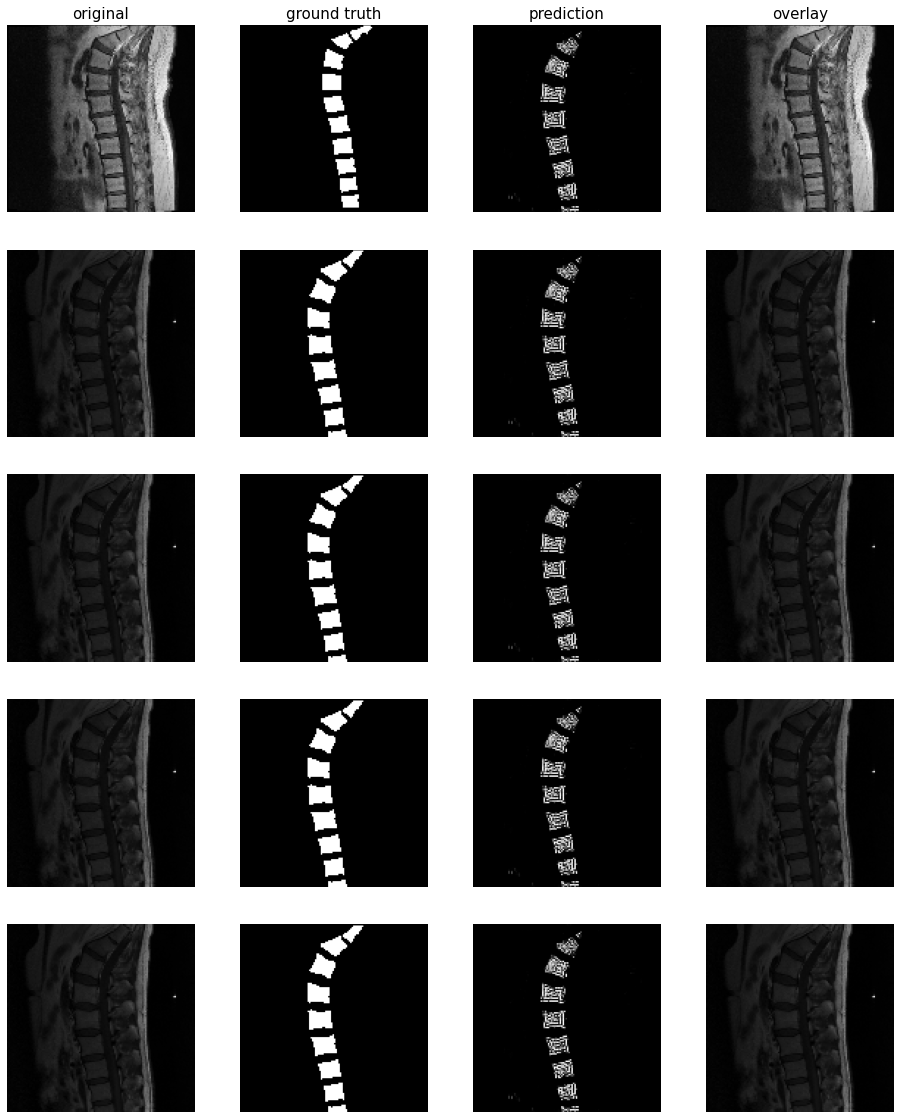

In [16]:
num = 16
plot_imgs(org_imgs=x_val[:,:,:,num,0], mask_imgs=y_val[:,:,:,num,0], pred_imgs=y_pred[:,:,:,num,0], nm_img_to_plot=5)